In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import h5py 


from evaluation import *
np.random.seed(5)

In [2]:
from sklearn.mixture import GaussianMixture

In [3]:
import scipy.io
mat = scipy.io.loadmat('/Users/OlgaKo/Desktop/one_plus_e/datasets/thyroid.mat')

X_data = mat["X"]
X_data = StandardScaler().fit_transform(X_data)

labels = mat["y"]

In [4]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, test_size=0.5, random_state = 5)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
X_good = X_train[np.where(y_train==0)[0]]

In [7]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [8]:
gm = GaussianMixture(n_components=7, n_init=6, verbose=2)

In [9]:
gm.fit(X_good)

Initialization 0
  Iteration 0	 time lapse 0.02381s	 ll change inf
  Iteration 10	 time lapse 0.05622s	 ll change 0.02768
  Iteration 20	 time lapse 0.04928s	 ll change 0.00724
  Iteration 30	 time lapse 0.04708s	 ll change 0.00547
  Iteration 40	 time lapse 0.04460s	 ll change 0.00105
Initialization converged: True	 time lapse 0.22755s	 ll -1.68648
Initialization 1
  Iteration 0	 time lapse 0.03703s	 ll change inf
  Iteration 10	 time lapse 0.05064s	 ll change 0.00985
  Iteration 20	 time lapse 0.05534s	 ll change 0.00867
Initialization converged: True	 time lapse 0.19337s	 ll -1.86556
Initialization 2
  Iteration 0	 time lapse 0.06180s	 ll change inf
  Iteration 10	 time lapse 0.06404s	 ll change 0.02410
  Iteration 20	 time lapse 0.06348s	 ll change 0.00447
  Iteration 30	 time lapse 0.04686s	 ll change 0.00357
  Iteration 40	 time lapse 0.05090s	 ll change 0.00352
  Iteration 50	 time lapse 0.05789s	 ll change 0.00199
Initialization converged: True	 time lapse 0.35042s	 ll -1.49060

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=6, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=2,
        verbose_interval=10, warm_start=False, weights_init=None)

In [10]:
from scipy.stats import multivariate_normal

In [11]:
n_samples = X_good.shape[0]

In [12]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], size=int(gm.weights_[0]*n_samples)))
for d in range(1,gm.n_components):
    gen=np.vstack((gen,multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=int(gm.weights_[d]*n_samples))))
np.random.shuffle(gen)
gen = np.array(gen)

In [13]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [14]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], 
                                                    cov=gm.covariances_[d], allow_singular=True)

In [15]:
gen.shape

(1836, 6)

In [16]:
maxprob = np.max(probabilities, axis = 0)
gen_w = 1./(maxprob+1e-2)

In [17]:
#indices = gen_w.argsort()[-50:][::-1] #_toobig
#indices_toosmall = gen_w.argsort()[:200][::-1]

#indices = np.concatenate((indices_toosmall,indices_toobig))

In [18]:
#gen_w = np.delete(gen_w, indices)
#gen = np.delete(gen, indices, axis = 0)

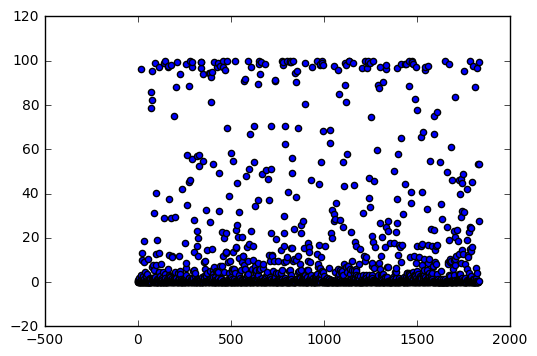

In [19]:
plt.scatter(np.arange(len(gen_w)), gen_w)
plt.show()

In [20]:
weights = np.ones((n_samples,1)) #X_train.shape[0]

In [21]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [22]:
gen_w_normed.sum(), np.sum(weights)

(1840.0, 1840.0)

In [23]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [24]:
X_mix = np.vstack((X_good, gen)) #X_good

y_mix = np.vstack((y1, y2)) #y_train

weights_mix = np.vstack((weights.reshape(-1,1), gen_w_normed.reshape(-1,1))).reshape(-1)

In [25]:
weights_mix.shape

(3676,)

In [26]:
import tensorflow as tf

s = tf.InteractiveSession()

import keras
from keras.models import Sequential
from keras import layers as L

Using TensorFlow backend.


In [27]:
net = Sequential()
net.add(L.Dense(64, input_shape=(6,), activation = 'relu'))
#net.add(L.BatchNormalization())
#net.add(L.Dense(32, activation='relu'))
net.add(L.BatchNormalization())
net.add(L.Dropout(0.2))
net.add(L.Dense(1, activation='sigmoid'))

adam = keras.optimizers.Adam(lr=0.001)
net.compile(optimizer=adam, loss='binary_crossentropy')

In [28]:
history = net.fit(X_mix, y_mix, batch_size=256, epochs=120, validation_split = 0.1, verbose=2, shuffle=True, sample_weight=weights_mix)

Train on 3308 samples, validate on 368 samples
Epoch 1/120
0s - loss: 1.2937 - val_loss: 1.0022
Epoch 2/120
0s - loss: 1.0461 - val_loss: 0.9127
Epoch 3/120
0s - loss: 0.9017 - val_loss: 0.8537
Epoch 4/120
0s - loss: 0.7782 - val_loss: 0.8547
Epoch 5/120
0s - loss: 0.6933 - val_loss: 0.8626
Epoch 6/120
0s - loss: 0.6419 - val_loss: 0.8775
Epoch 7/120
0s - loss: 0.6207 - val_loss: 0.9136
Epoch 8/120
0s - loss: 0.6052 - val_loss: 0.9445
Epoch 9/120
0s - loss: 0.5595 - val_loss: 0.9636
Epoch 10/120
0s - loss: 0.5707 - val_loss: 0.9754
Epoch 11/120
0s - loss: 0.5335 - val_loss: 0.9915
Epoch 12/120
0s - loss: 0.5533 - val_loss: 1.0016
Epoch 13/120
0s - loss: 0.5305 - val_loss: 1.0059
Epoch 14/120
0s - loss: 0.5373 - val_loss: 0.9989
Epoch 15/120
0s - loss: 0.5517 - val_loss: 0.9790
Epoch 16/120
0s - loss: 0.5261 - val_loss: 0.9633
Epoch 17/120
0s - loss: 0.5177 - val_loss: 0.9548
Epoch 18/120
0s - loss: 0.5286 - val_loss: 0.9470
Epoch 19/120
0s - loss: 0.5090 - val_loss: 0.9185
Epoch 20/120

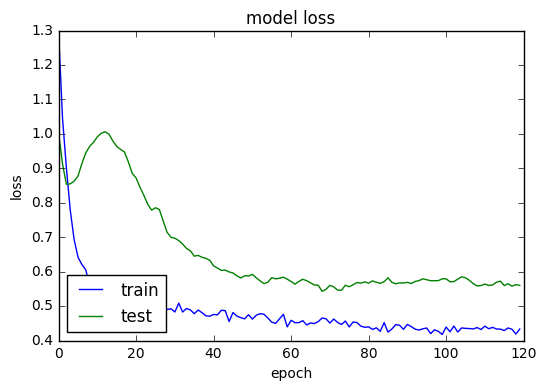

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

1120/1886 [================>.............] - ETA: 0s
recall_score  1.0
precision_score  0.170909090909
f1_score  0.291925465839
confusion_matrix 
[[1611  228]
 [   0   47]]


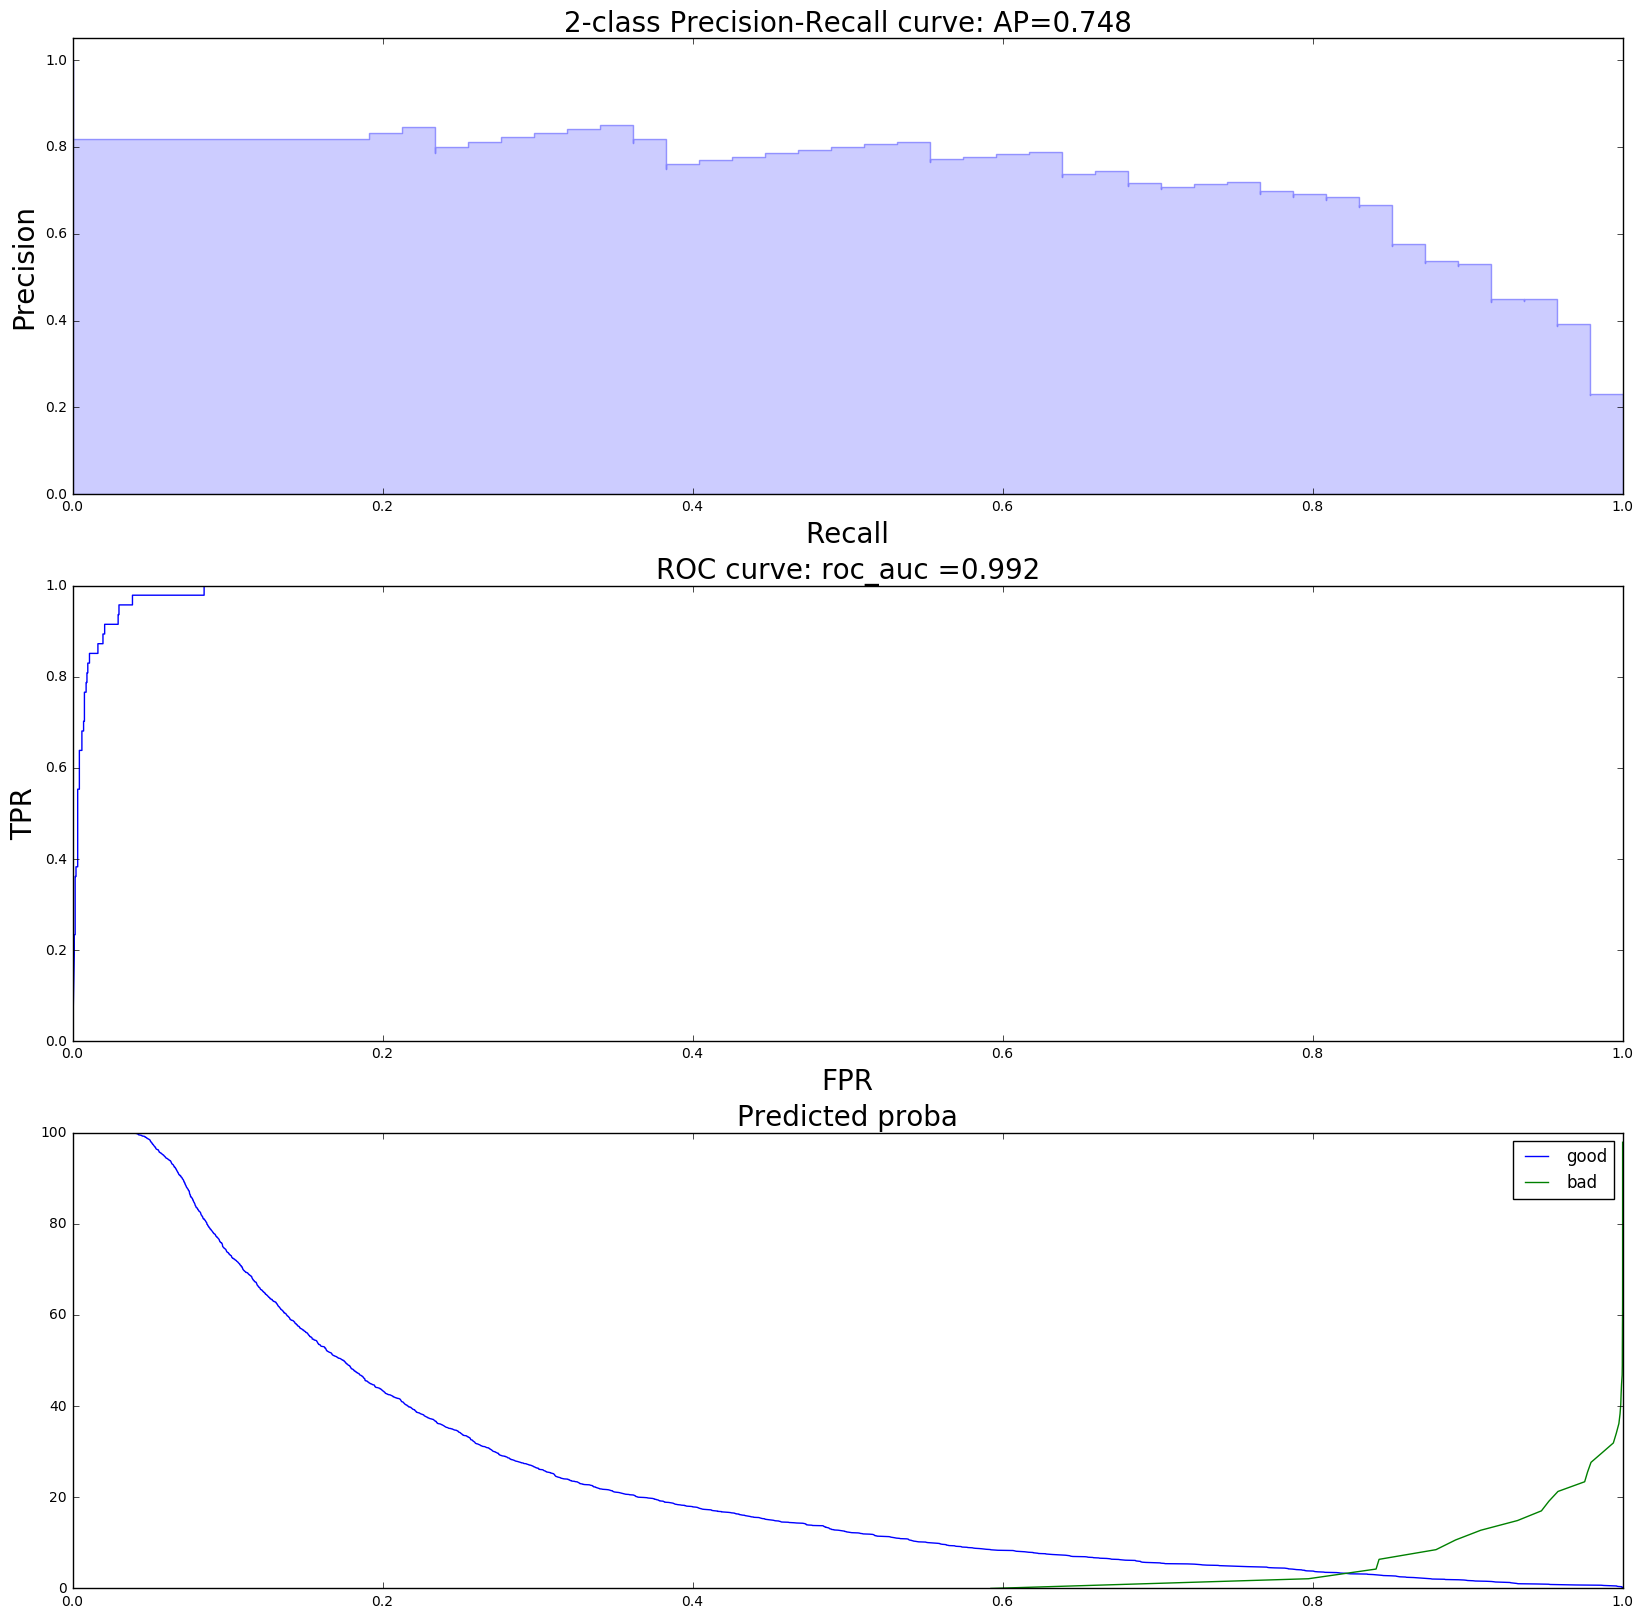

In [30]:
y_pred = net.predict(X_test, verbose=1)
print ('')
perfomance(y_test, y_pred)

## Classic methods

In [31]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [32]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)}


for i, (clf_name, clf) in enumerate(classifiers_classic.items()):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))

One-Class SVM
recall_score  0.914893617021
precision_score  0.405660377358
f1_score  0.562091503268
confusion_matrix 
[[1776   63]
 [   4   43]]
Isolation Forest
recall_score  0.978723404255
precision_score  0.438095238095
f1_score  0.605263157895
confusion_matrix 
[[1780   59]
 [   1   46]]
